### Uncomment the following blocks in order to install dependencies in Google Colab

In [1]:
# ! git clone https://github.com/zhendong3wang/learning-time-series-counterfactuals.git 

In [2]:
# ! cd learning-time-series-counterfactuals && git checkout ds_extension

In [3]:
# ! pip install -r learning-time-series-counterfactuals/requirements.txt

In [4]:
# import sys
# sys.path.append('./learning-time-series-counterfactuals/src')
# sys.path.append('./learning-time-series-counterfactuals/LIMESegment/Utils/')

### Actual codes start

In [5]:
import logging
import os
import warnings
from argparse import ArgumentParser

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals

from _composite import ModifiedLatentCF
from _vanilla import LatentCF
from help_functions import (ResultWriter, conditional_pad, evaluate,
                            find_best_alpha, find_best_lr, plot_graphs,
                            reset_seeds, time_series_normalize,
                            time_series_revert, upsample_minority,
                            validity_score)
from keras_models import *

2022-07-03 00:37:08.632653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-07-03 00:37:11.215117: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-03 00:37:11.215274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-03 00:37:11.215444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 00:37:11.215803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:42:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2022-07-03 00:37:11.215817: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-03 00:37:11.217336: I tensorflow/stream_executor/platform/def

In [7]:
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


2022-07-03 00:37:11.242843: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-03 00:37:11.245041: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-03 00:37:11.245353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 00:37:11.245975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:42:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2022-07-03 00:

In [9]:
logger = logging.getLogger(__name__)
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}.")
RANDOM_STATE = 39

DATASET_NAME = "FordA"
OUTPUT_FILENAME = "FordA-outfile.csv"
result_writer = ResultWriter(file_name=OUTPUT_FILENAME, dataset_name=DATASET_NAME)
logger.info(f"Result writer is ready, writing to {OUTPUT_FILENAME}...")
result_writer.write_head()


In [11]:
# 1. Load data
X, y = load_dataset(DATASET_NAME, repository="wildboar/ucr")

pos = 1
neg = -1
# Convert positive and negative labels to 1 and 0
pos_label, neg_label = 1, 0
y_copy = y.copy()
if pos != pos_label:
    y_copy[y==pos] = pos_label # convert/normalize positive label to 1
if neg != neg_label:
    y_copy[y==neg] = neg_label # convert negative label to 0

X_train, X_test, y_train, y_test = train_test_split(X, y_copy, test_size=0.2, random_state=RANDOM_STATE, stratify=y_copy) 

# Upsample the minority class
y_train_copy = y_train.copy()
X_train, y_train = upsample_minority(X_train, y_train, pos_label=pos_label, neg_label=neg_label)
if y_train.shape != y_train_copy.shape:
    logger.info(f"Data upsampling performed, current distribution of y: \n{pd.value_counts(y_train)}.")


In [12]:
# ### 1.1 Normalization - fit scaler using training data 
n_training, n_timesteps = X_train.shape
n_features = 1

X_train_processed, trained_scaler = time_series_normalize(data=X_train, n_timesteps=n_timesteps)
X_test_processed, _ = time_series_normalize(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler)

X_train_processed_padded, padding_size = conditional_pad(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad(X_test_processed) 
n_timesteps_padded = X_train_processed_padded.shape[1]
logger.info(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")


In [13]:
y_train_classes = y_train
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

In [14]:
n_lstmcells = 8

# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()

###############################################
# ## 2.0 LSTM-FCN classifier
###############################################
# ### LSTM-FCN classifier
classifier = LSTMFCNClassifier(
    n_timesteps_padded, n_features, n_output=2, n_LSTM_cells=n_lstmcells
)

optimizer = keras.optimizers.Adam(lr=0.0001)
classifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
# Train the model
reset_seeds()
logger.info("Training log for LSTM-FCN classifier:")
classifier_history = classifier.fit(
    X_train_processed_padded,
    y_train,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(X_test_processed_padded, y_test),
    callbacks=[early_stopping_accuracy],
)

y_pred = classifier.predict(X_test_processed_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:pos", "True:neg"],
    columns=["Pred:pos", "Pred:neg"],
)
print(f"Confusion matrix: \n{confusion_matrix_df}.")

2022-07-03 00:37:24.256203: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-03 00:37:24.256456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 00:37:24.256827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:42:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2022-07-03 00:37:24.256855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-03 00:37:24.256890: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-03 00:37:24.256902: I tensorflow/stream_executor/platform/

Epoch 1/150


2022-07-03 00:37:25.862007: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-03 00:37:26.172785: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-07-03 00:37:26.176931: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


127/127 [==============================] - 7s 29ms/step - loss: 0.6906 - accuracy: 0.6099 - val_loss: 0.6898 - val_accuracy: 0.6000
Epoch 2/150
127/127 [==============================] - 3s 26ms/step - loss: 0.5285 - accuracy: 0.7794 - val_loss: 0.6737 - val_accuracy: 0.5594
Epoch 3/150
127/127 [==============================] - 3s 27ms/step - loss: 0.4328 - accuracy: 0.8345 - val_loss: 0.6160 - val_accuracy: 0.6792
Epoch 4/150
127/127 [==============================] - 3s 27ms/step - loss: 0.3635 - accuracy: 0.8785 - val_loss: 0.5306 - val_accuracy: 0.7523
Epoch 5/150
127/127 [==============================] - 3s 27ms/step - loss: 0.3041 - accuracy: 0.9088 - val_loss: 0.4897 - val_accuracy: 0.7584
Epoch 6/150
127/127 [==============================] - 3s 26ms/step - loss: 0.2489 - accuracy: 0.9295 - val_loss: 0.4682 - val_accuracy: 0.7756
Epoch 7/150
127/127 [==============================] - 3s 26ms/step - loss: 0.2100 - accuracy: 0.9432 - val_loss: 0.4724 - val_accuracy: 0.7706
Epoc

## 1dCNN search

In [15]:
###############################################
# ## 2.1 CF search with 1dCNN autoencoder
###############################################
# ### 1dCNN autoencoder
autoencoder = Autoencoder(n_timesteps_padded, n_features)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True
)
# Train the model
reset_seeds()
logger.info("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train_processed_padded,
    X_train_processed_padded,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(X_test_processed_padded, X_test_processed_padded),
    callbacks=[early_stopping],
)

ae_val_loss = np.min(autoencoder_history.history["val_loss"])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


Epoch 1/50


2022-07-03 00:42:37.987920: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 3.84G (4122279936 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


127/127 [==============================] - 4s 22ms/step - loss: 0.0484 - val_loss: 7.2976e-04
Epoch 2/50
127/127 [==============================] - 2s 18ms/step - loss: 4.5617e-04 - val_loss: 9.3116e-05
Epoch 3/50
127/127 [==============================] - 2s 19ms/step - loss: 6.8023e-05 - val_loss: 3.1020e-05
Epoch 4/50
127/127 [==============================] - 2s 18ms/step - loss: 2.8722e-05 - val_loss: 2.0638e-05
Epoch 5/50
127/127 [==============================] - 2s 18ms/step - loss: 1.9092e-05 - val_loss: 1.8826e-05
Epoch 6/50
127/127 [==============================] - 2s 19ms/step - loss: 1.5172e-05 - val_loss: 1.2291e-05
Epoch 7/50
127/127 [==============================] - 2s 19ms/step - loss: 1.2587e-05 - val_loss: 1.2672e-05
1dCNN autoencoder trained, with validation loss: 1.2291021448618267e-05.


## CF search, original

In [76]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [1]
w_type = "global"

if w_type == "global":
    step_weights = get_global_weights(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res = evaluate(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



======================== CF search started, with lr=0.0001.
0 samples been transformed.
lr=0.0001 finished. Validity: 0.9, proximity (with padding): 0.34743109844480335, margin difference: (-0.0022374392, 0.00851457).
The best learning rate found is 0.0001.


In [77]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


Done for CF search [1dCNN autoencoder], pred_margin_weight=1.


In [78]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [79]:
sample_id = 0

In [81]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

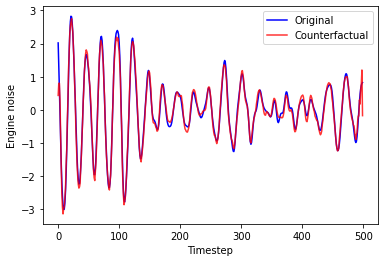

In [99]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original")
plt.plot(cf_sample, color='r', alpha=0.8, label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Engine noise")
plt.legend()
# plt.grid()
plt.show()

In [74]:
print(z_pred[sample_id])

0.50083226


## NoAE search

In [ ]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res3 = evaluate(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(z_pred3[sample_id])

## global, pred_margin_weight = 0.5

In [56]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
w_type = "global"

if w_type == "global":
    step_weights = get_global_weights(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res = evaluate(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



======================== CF search started, with lr=0.0001.
0 samples been transformed.
lr=0.0001 finished. Validity: 0.8, proximity (with padding): 0.2902330419952558, margin difference: (-0.09957275, 0.20021379).
The best learning rate found is 0.0001.


In [57]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


Done for CF search [1dCNN autoencoder], pred_margin_weight=0.5.


In [58]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [59]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

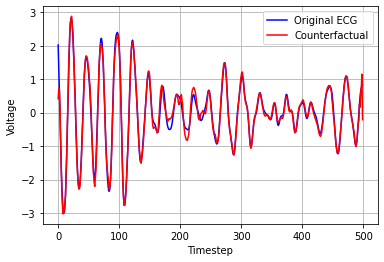

In [60]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [61]:
print(z_pred[sample_id])

0.50029844


In [62]:
from wildboar.explain import *

class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        p = self.model.predict(X.reshape(X.shape[0], -1, 1))
        return np.argmax(p, axis=1) # I think this would work?

    def fit(self, X, y):
        return self.model.fit(X, y)

clf = ModelWrapper(classifier)

i = IntervalImportance(scoring="accuracy", n_interval=10, random_state=RANDOM_STATE)
i.fit(clf, X_train_processed_padded.reshape(X_train_processed_padded.shape[0], -1), y_train_classes)


IntervalImportance(n_interval=10, random_state=39, scoring='accuracy')

In [63]:
print(i.importances_.mean)

[0.04294904 0.04868877 0.039238   0.04814448 0.05432954 0.04799604
 0.04661059 0.04433449 0.03374567 0.03612073]


In [64]:
seg_idx = i.intervals_
seg_imp = i.importances_.mean

In [65]:
# calculate the threshold of masking, 75 percentile
masking_threshold = np.percentile(seg_imp, 75)
# masking_threshold = np.percentile(i.importances_.mean, 25)
print(masking_threshold)
masking_idx = np.where(seg_imp >= masking_threshold)
print(masking_idx)
weighted_steps = np.ones(X_test_processed_padded.shape[1])
print(weighted_steps.shape)

for start_idx in masking_idx[0]:
    weighted_steps[seg_idx[start_idx][0] : seg_idx[start_idx][1]] = 0


0.04810737258782778
(array([1, 3, 4]),)
(500,)


In [66]:
masking_threshold

0.04810737258782778

0, 50: 0.04294903513112316
50, 100: 0.04868876793666497
100, 150: 0.03923800098960908
150, 200: 0.048144482929242935
200, 250: 0.0543295398317664
250, 300: 0.04799604156358235
300, 350: 0.046610588817417066
350, 400: 0.04433448787728844
400, 450: 0.03374567046016819


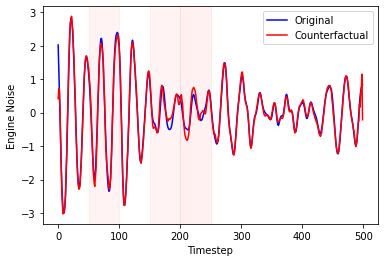

In [67]:
import math

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Engine Noise")
plt.legend()

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i][0]
    end = seg_idx[i+1][0] 
    print(f'{start}, {end}: {weight}')
    if weight <= masking_threshold: 
        continue
    color = 'red' # if weight < 0 else 'green' 
    plt.axvspan(start, end, color=color, alpha=abs(weight))

# plt.grid()
plt.show()
    

## NoAE search

In [ ]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res3 = evaluate(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [ ]:
step_weights.reshape(-1)

In [ ]:
print(z_pred3[sample_id])

## local, pred_margin_weight = 0.5

In [36]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
w_type = "local"

if w_type == "global":
    step_weights = get_global_weights(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res = evaluate(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



======================== CF search started, with lr=0.0001.
0 samples been transformed.
lr=0.0001 finished. Validity: 0.8, proximity (with padding): 0.3338446707290844, margin difference: (-0.09846681, 0.20076622).
The best learning rate found is 0.0001.


In [37]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


Done for CF search [1dCNN autoencoder], pred_margin_weight=0.5.


In [38]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [39]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

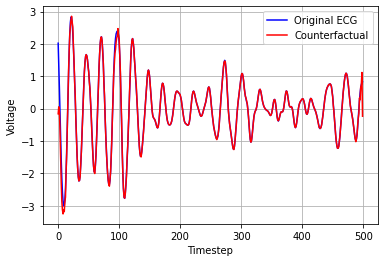

In [40]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [41]:
print(z_pred[sample_id])

8.544079e-05


In [42]:
from LIMESegment.Utils.explanations import LIMESegment

series = X_pred_neg[sample_id]

seg_imp, seg_idx = LIMESegment(
        series,
        classifier,
        model_type=1,
        cp=10,
        window_size=10,
        random_state=RANDOM_STATE,
    )

/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
# seg_imp, seg_idx = explanations
total_len = len(series)
seg_idx[-1] = total_len - padding_size
# seg_idx[-1] = total_len

In [44]:
# calculate the threshold of masking, 25 percentile
masking_threshold = np.percentile(seg_imp, 25)
masking_idx = np.where(seg_imp <= masking_threshold)

masking_threshold

-0.14271100832328185

0, 13: -0.31355685763561303
13, 20: 0.02919761024329733
20, 25: -0.317918408494908
25, 32: 0.032747181800924334
32, 63: 0.07086116162867091
63, 87: 0.060695662253608826
87, 92: -0.09840160540550194
92, 101: -0.17291956752246876
101, 107: 0.13488753173887116
107, 120: -0.11250244912409493
120, 500: -0.021255619184438516


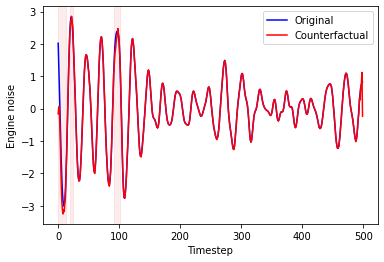

In [55]:
import math

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Engine noise")
plt.legend(loc='upper right')

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i]
    end = seg_idx[i+1] 
    print(f'{start}, {end}: {weight}')
    if weight >= masking_threshold: 
        continue
    color = 'lightcoral' #if weight < 0 else 'green' 
    plt.axvspan(start, end, color=color, alpha=0.15)#abs(weight))

# plt.grid()
plt.show()

In [46]:
from LIMESegment.Utils.explanations import LIMESegment

def get_local_weights(input_sample, classifier_model, random_state=None):
    n_timesteps, n_dims = input_sample.shape  # n_dims=1
    seg_imp, seg_idx = LIMESegment(
        input_sample,
        classifier_model,
        model_type=1,
        cp=10,
        window_size=10,
        random_state=random_state,
    )

    # calculate the threshold of masking, 25 percentile
    masking_threshold = np.percentile(seg_imp, 25)
    masking_idx = np.where(seg_imp <= masking_threshold)

    weighted_steps = np.ones(n_timesteps)
    for start_idx in masking_idx[0]:
        weighted_steps[seg_idx[start_idx] : seg_idx[start_idx + 1]] = 0

    # need to reshape for multiplication in `tf.math.multiply()`
    weighted_steps = weighted_steps.reshape(1, n_timesteps, n_dims)
    return weighted_steps

In [47]:
series = X_pred_neg[sample_id]

step_weights = get_local_weights(
    series, classifier, random_state=RANDOM_STATE
)

/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/dsv/zhwa9764/miniconda3/envs/ds-ext/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
step_weights.reshape(-1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

## NoAE search

In [ ]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res3 = evaluate(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(z_pred3[sample_id])

## uniform, pred_margin_weight = 0.5

In [ ]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
w_type = "uniform"

if w_type == "global":
    step_weights = get_global_weights(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res = evaluate(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



In [ ]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(z_pred[sample_id])

## NoAE search

In [ ]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res3 = evaluate(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [ ]:
step_weights.reshape(-1)

In [ ]:
print(z_pred3[sample_id])